# Data creation for English language samples only

# 1)- Importing Key Modules

In [1]:
# support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import numpy as np 
import pandas as pd 

#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [3]:
#models and evaluation

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from nltk.classify.scikitlearn import SklearnClassifier # notice its from ntlk not sklearn
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
# Evaluation packages
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [4]:
#pip install version_information
%reload_ext version_information
%version_information pandas,numpy, nltk, seaborn, matplotlib

Software versions
Python 3.7.7 64bit [MSC v.1916 64 bit (AMD64)]
IPython 7.13.0
OS Windows 10 10.0.17763 SP0
pandas 1.0.3
numpy 1.18.1
nltk 3.5
seaborn 0.10.1
matplotlib 3.1.3
Fri Jun 26 14:52:06 2020 W. Europe Daylight Time

# 2)-Loading data

In [5]:
data=pd.read_excel('data_3655_eng.xlsx')
data=data.rename(columns={'Unnamed: 0':'random_columns'}) # a trick to tackle random index values
data.shape

(3655, 8)

In [6]:
data.head()

,random_columns,firstmessage,dep,firstusedtextblock,language,ticketnumber,USSD,UKSD
0,0,Hello:<br><br>I tried to apply a voucher to th...,Shipping issues,nichtkombiwb,English (GB),USSD200027656,True,False
1,9,WOW WOW WOW! I'm so in love with my acrylic co...,Customer feedback,feedback,English (GB),USSD200027393,True,False
2,11,<p>Wanted to check and see if my order has shi...,Order management,renscom,English (GB),USSD200027388,True,False
3,12,This book is a great way to showcase the photo...,ShareWithSaal,teilen2,English (GB),USSD200027385,True,False
4,19,"Sehr geehrte Damen & Herren,<br> <br>wir möcht...",Shipping issues,vdn,English (GB),USSD200027372,True,False


In [7]:
data.tail()

,random_columns,firstmessage,dep,firstusedtextblock,language,ticketnumber,USSD,UKSD
3650,9450,Lang : en_GB<br />Sub...,Reseller workflow,rsgs,English (GB),UKSD190000184,False,True
3651,9453,Lang : en_GB<br />Sub...,Reseller workflow,rsinfo,English (GB),UKSD190000148,False,True
3652,9462,Lang : en_GB<br />Sub...,Special conditions,VDN,English (GB),UKSD190000082,False,True
3653,9463,Lang : en_GB<br />Sub...,Marketing,vdn,English (GB),UKSD190000073,False,True
3654,9469,Lang : en_GB<br />Sub...,Reseller workflow,rsgs,English (GB),UKSD190000050,False,True


### Checking for text data

In [8]:
data['firstmessage'][2]

'<p>Wanted to check and see if my order has shipped yet. Thanks.&nbsp;<br />Jack<br />703-623-9876</p>'

### checking for department

In [9]:
data['dep'].nunique()

22

In [10]:
data['dep'].unique()

array(['Shipping issues', 'Customer feedback', 'Order management',
       'ShareWithSaal', 'Software/Webshop/App',
       'product complaints - products (Reklamation Produkte)',
       'product complaints - colours (Reklamation Farben)',
       'Data protection (Datenschutz)',
       'Professional area (Profibereich)', 'Payment (Bezahlung)',
       'Product (Produkt)', 'Marketing',
       'product complaints - software (Reklamation Software)',
       'Musterbuch', 'Special conditions', 'Discovery voucher',
       'Production delays', 'Reseller workflow', 'Reseller whitelabel ',
       'Samplebook-ProLine', 'Rücksendung', 'Inkasso'], dtype=object)

In [11]:
data['dep'].value_counts()

Order management                                        1449
Software/Webshop/App                                     417
Customer feedback                                        394
ShareWithSaal                                            323
product complaints - products (Reklamation Produkte)     265
Marketing                                                138
Shipping issues                                          131
Product (Produkt)                                        104
product complaints - colours (Reklamation Farben)         91
Professional area (Profibereich)                          76
Special conditions                                        55
Payment (Bezahlung)                                       49
Data protection (Datenschutz)                             34
Production delays                                         31
Discovery voucher                                         28
Reseller workflow                                         26
Rücksendung             

### Checking for response variable

In [12]:
data['firstusedtextblock'].nunique()

267

In [13]:
data['firstusedtextblock'].value_counts()[:20]

renscom           803
teilen2           307
vdn               244
feedback          186
tuto              125
csfeed             83
fuo                76
pay                69
vdv                62
colnf11            51
saa                49
softissue          47
rf                 46
protectivefilm     43
fus                42
aufsta             41
rekla              39
sorry              37
liad               36
zuge               31
Name: firstusedtextblock, dtype: int64

# 3)-Preprocessing 

### 3.1)- Missing values

In [14]:
# Checking rows now
def summary_missing(dataset):
    n_miss = dataset.isnull().sum()
    n_obs = dataset.shape[0]
    n_miss_per = n_miss/n_obs*100
    n_miss_tbl = pd.concat([n_miss, n_miss_per], axis = 1).sort_values(1, ascending = False).round(1)
    n_miss_tbl = n_miss_tbl[n_miss_tbl[1] != 0]
    print('No. of fields: ', dataset.shape[0])
    print('No. of missing fields: ', n_miss_tbl.shape[0])
    n_miss_tbl = n_miss_tbl.rename(columns = {0:'No. of mising Value', 1:'%age of missing Value'})
    return n_miss_tbl

In [15]:
summary_missing(data)

No. of fields:  3655
No. of missing fields:  2


,No. of mising Value,%age of missing Value
firstmessage,454,12.4
firstusedtextblock,2,0.1


### Fixing missing value issue

In [16]:
data=data.fillna('other')

In [17]:
summary_missing(data)

No. of fields:  3655
No. of missing fields:  0


,No. of mising Value,%age of missing Value


### Data Cleaning

In [18]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hassan.sherwani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
def preprocess(ReviewText):
    ReviewText = ReviewText.str.replace("(<br>)", "")
    ReviewText = ReviewText.str.replace("(<br />)", "")
    ReviewText = ReviewText.str.replace('(<p>)', '')
    ReviewText = ReviewText.str.replace('( </p>)', '')
    ReviewText = ReviewText.str.replace('(;</p>)', '')
    ReviewText = ReviewText.str.replace('(&rsquo;)', '')
    ReviewText = ReviewText.str.replace('(&rdquo;)', '')
    ReviewText = ReviewText.str.replace('(&ldquo;)', '')
    ReviewText = ReviewText.str.replace('(&nbsp)', ' ')  
    ReviewText = ReviewText.str.replace('(www)', ' ') 
    ReviewText = ReviewText.str.replace('(https)', ' ') 
    ReviewText = ReviewText.str.replace('(http)', ' ') 
    return ReviewText
data['clean'] = preprocess(data['firstmessage'])

In [20]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;#]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z +_]')
STOPWORDS = stopwords.words('english')
STOPWORDS.extend(['http','https']) # extend stopwords; rt means re-tweet
STOPWORDS = set(STOPWORDS)

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwords from text
    text = text.strip()
    return text

In [21]:
data['clean']=[text_prepare(x) for x in data['clean']]

In [22]:
# Dictionary of all words from train corpus with their counts.
words_counts = {}

from collections import Counter
words_counts = Counter([word for line in data['clean'] for word in line.split(' ')])

# Sorting 
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Top 10
most_common_words[:10]

[('order', 2067),
 ('book', 1770),
 ('saal', 1344),
 ('would', 1175),
 ('photo', 1044),
 ('photobook', 942),
 ('software', 937),
 ('digital', 804),
 ('please', 795),
 ('quality', 775)]

### Lemma

In [23]:
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()

In [24]:
tokenized_text = data['clean'].apply(lambda x: x.split()) # tokenizing 
print(tokenized_text[9])

['huge', 'grateful', 'shoutout', 'saaldigital_corp', 'giving', 'opportunity', 'create', 'professional', 'portfolio', 'photobook', 'showcase', 'photography', 'saal', 'photobooks', 'amazing', '12x12', 'professional', 'line', 'xt', 'photobook', 'arrived', 'leatherbound', 'gift', 'box', 'leather', 'binding', 'well', '1', '8', 'thick', 'acrylic', 'cover', 'extra', 'thick', 'matte', 'finish', 'photographic', 'artboard', 'pages', 'perfect', 'colour', 'representation', 'plenty', 'room', 'fullsize', '8x10', 'photos', 'super', 'proud', 'book', 'highly', 'recommend', 'saal', 'photographer', 'looking', 'impress', 'canon', 'eos', '70d', '35mm', 'f', '50', 'iso', '800', '1', '100', '27', 'may', '2020', 'photography', 'professional', 'professionalphotographer', 'professionalphotography', 'professionalline', 'photobook', 'portfolio', 'saaldigital', 'therealjeffwilliams']


In [25]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hassan.sherwani\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [26]:
tokenized_text = tokenized_text.apply(lambda x: [lemm.lemmatize(i) for i in x])
print(tokenized_text[2])

['wanted', 'check', 'see', 'order', 'shipped', 'yet', 'thanks', 'jack7036239876', 'p']


##### using stemmer

In [27]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer(language='english')

In [28]:
tokenized_text = data['clean'].apply(lambda x: x.split()) # tokenizing 
tokenized_text = tokenized_text.apply(lambda x: [stemmer.stem(i) for i in x])
print(tokenized_text[2])

['want', 'check', 'see', 'order', 'ship', 'yet', 'thank', 'jack7036239876', 'p']


stemmer works better in our case, we shall go for it

In [29]:
# stitch these tokens back together.

for i in range(len(tokenized_text)):
    tokenized_text[i] = ' '.join(tokenized_text[i])    
data['clean'] = tokenized_text

In [30]:
#before clean
data['firstmessage'].apply(lambda x: len(x.split(' '))).sum()

268896

In [31]:
#after clean
data['clean'].apply(lambda x: len(x.split(' '))).sum()

131839

##### save for future

In [32]:
data.head(2)

,random_columns,firstmessage,dep,firstusedtextblock,language,ticketnumber,USSD,UKSD,clean
0,0,Hello:<br><br>I tried to apply a voucher to th...,Shipping issues,nichtkombiwb,English (GB),USSD200027656,True,False,helloi tri appli voucher order receiv mail did...
1,9,WOW WOW WOW! I'm so in love with my acrylic co...,Customer feedback,feedback,English (GB),USSD200027393,True,False,wow wow wow im love acryl cover pro photo book...


In [33]:
df_clean = data[['clean','firstmessage','dep','firstusedtextblock']]

In [34]:
df_clean.to_excel('clean_3655_eng.xlsx')

# 4)- Model Building:For Intent

Chatbot consists of two predictve models i.e intent and response.

In [35]:
#Function for category id
data['category_id'] = data['dep'].factorize()[0]
category_id_df = data[['dep', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'dep']].values)

In [36]:
#vectorization
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(data.clean).toarray()
labels = data['dep'].astype(str)
features.shape

(3655, 4349)

In [37]:
# model fit

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [38]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.400821
1,RandomForestClassifier,1,0.404925
2,RandomForestClassifier,2,0.406293
3,RandomForestClassifier,3,0.400821
4,RandomForestClassifier,4,0.399453
5,LinearSVC,0,0.538988
6,LinearSVC,1,0.499316
7,LinearSVC,2,0.541724
8,LinearSVC,3,0.571819
9,LinearSVC,4,0.567715


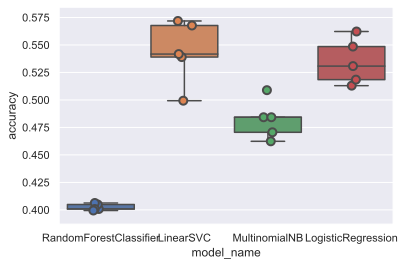

In [39]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [40]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.543912
LogisticRegression        0.534610
MultinomialNB             0.482079
RandomForestClassifier    0.402462
Name: accuracy, dtype: float64

### Model Evaluation

In [41]:
model1 = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, data.index, test_size=0.33, random_state=0)

In [42]:
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.5675227837613919


In [81]:
y_pred[:5]

array(['renscom', 'vdn', 'feedback', 'vdn', 'renscom'], dtype=object)

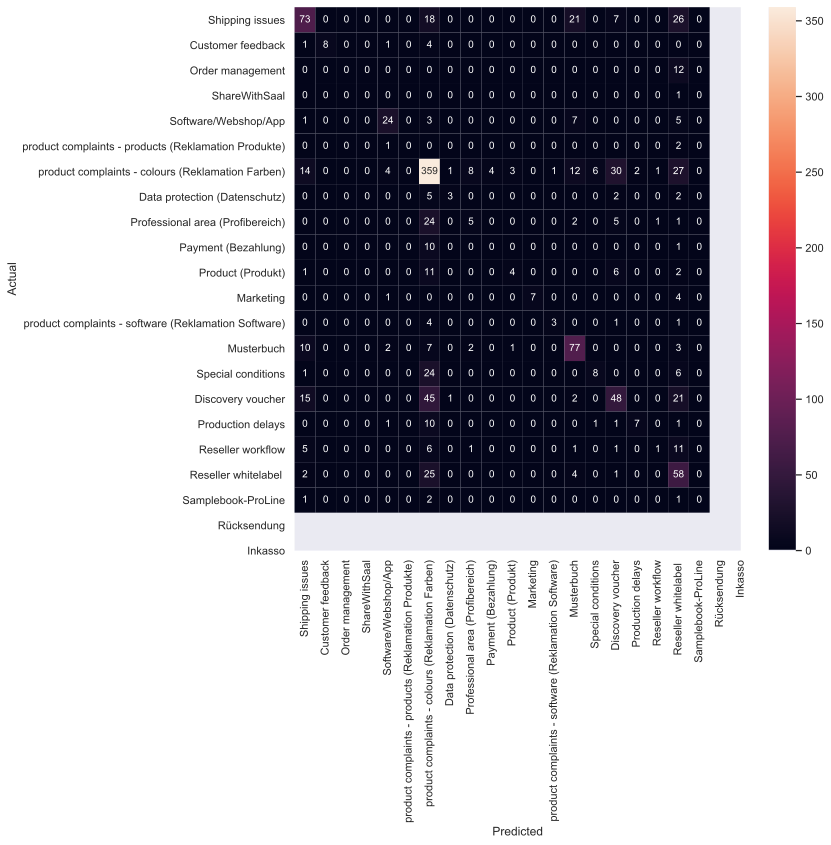

In [43]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.dep.values, yticklabels=category_id_df.dep.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [44]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

                                                      precision    recall  f1-score   support

                                   Customer feedback       0.59      0.50      0.54       145
                       Data protection (Datenschutz)       1.00      0.57      0.73        14
                                   Discovery voucher       0.00      0.00      0.00        12
                                             Inkasso       0.00      0.00      0.00         1
                                           Marketing       0.71      0.60      0.65        40
                                          Musterbuch       0.00      0.00      0.00         3
                                    Order management       0.64      0.76      0.70       472
                                 Payment (Bezahlung)       0.60      0.25      0.35        12
                                   Product (Produkt)       0.31      0.13      0.19        38
                                   Production delays       

In [45]:
print(labels.nunique())
print(y_train.nunique())
print(y_test.nunique())

22
21
20


### Summary:

- Accuracy = 56.75%
- Precision = 56%  
- Recall= 57% 
- F1-score= 55% 
- (test samples=1207)
- No. of classes in test data = 20
- No. of classes in train data = 21
- Total Classes = 22

### api

- key: text
- output1: class prediction
- output2: probability of each class (higher is better)

In [46]:
texts=["I was asked to test a saal photobook and I was so delighted with the result! It arrived with in 10 days and was of such high quality, with a white leather look cover and an acrylic glass to protect the front photo. It has made a lovely lockdown gift for my best friend."]

In [47]:
text_features = tfidf.transform(texts)
pred_class = model1.predict(text_features)
print('"{}"'.format(texts))
print("  - Predicted as: '{}'".format(pred_class))
print("")

"['I was asked to test a saal photobook and I was so delighted with the result! It arrived with in 10 days and was of such high quality, with a white leather look cover and an acrylic glass to protect the front photo. It has made a lovely lockdown gift for my best friend.']"
  - Predicted as: '['ShareWithSaal']'



In [48]:
pd.DataFrame(model1._predict_proba_lr(text_features), columns=model1.classes_)

,Customer feedback,Data protection (Datenschutz),Discovery voucher,Marketing,Musterbuch,Order management,Payment (Bezahlung),Product (Produkt),Production delays,Professional area (Profibereich),...,Reseller workflow,Rücksendung,Samplebook-ProLine,ShareWithSaal,Shipping issues,Software/Webshop/App,Special conditions,product complaints - colours (Reklamation Farben),product complaints - products (Reklamation Produkte),product complaints - software (Reklamation Software)
0,0.059757,0.042454,0.046188,0.046005,0.046066,0.029555,0.035882,0.055992,0.041573,0.047782,...,0.045498,0.043621,0.048843,0.087171,0.044847,0.056689,0.042186,0.048156,0.044129,0.043551


# 5)- Model2 : For Response

In [49]:
#function for category_id
data['category_id'] = data['firstusedtextblock'].factorize()[0]
category_id_df = data[['firstusedtextblock', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'firstusedtextblock']].values)

In [50]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(data.clean).toarray()
labels = data['firstusedtextblock']
features.shape

(3655, 4349)

In [51]:
%%time
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

Wall time: 1min 24s


In [52]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.224350
1,RandomForestClassifier,1,0.225718
2,RandomForestClassifier,2,0.227086
3,RandomForestClassifier,3,0.227086
4,RandomForestClassifier,4,0.228454
5,LinearSVC,0,0.288646
6,LinearSVC,1,0.269494
7,LinearSVC,2,0.292750
8,LinearSVC,3,0.314637
9,LinearSVC,4,0.320109


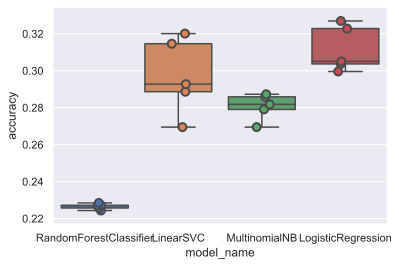

In [53]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [54]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.297127
LogisticRegression        0.311628
MultinomialNB             0.280711
RandomForestClassifier    0.226539
Name: accuracy, dtype: float64

### Evaluation

In [55]:
model2 = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, data.index, test_size=0.33, random_state=0)

In [56]:
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.30737365368682684


**confusion matrix is too large to display**

In [57]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

                    24h       0.00      0.00      0.00         1
                     50       0.00      0.00      0.00         7
              Auflösung       0.00      0.00      0.00         1
                 BREXIT       0.00      0.00      0.00         1
                Bsystem       0.00      0.00      0.00         2
                 DHLeid       0.00      0.00      0.00         1
             Erneuteing       0.00      0.00      0.00         2
                 NPorVO       0.00      0.00      0.00         2
                RENSCOM       0.00      0.00      0.00         1
             Systemzeit       0.00      0.00      0.00         2
                TEILEN2       0.00      0.00      0.00         2
                ThxFoto       0.00      0.00      0.00         1
                     VB       0.00      0.00      0.00         2
                    VDN       0.00      0.00      0.00         4
              adobedown 

In [58]:
print(labels.nunique())
print(y_train.nunique())
print(y_test.nunique())

268
226
182


### Summary:

- Accuracy = 30.73%
- Precision = 20 % 
- Recall= 31 %
- F1-score= 23 %
- (test samples=1207)
- No. of classes in test data=268
- No. classes in train data = 182
- Total classes = 268

# API

- key: text
- output1: class prediction
- output2: probability of each class (higher is better)

In [59]:
texts=["I was asked to test a saal photobook and I was so delighted with the result! It arrived with in 10 days and was of such high quality, with a white leather look cover and an acrylic glass to protect the front photo. It has made a lovely lockdown gift for my best friend."]

In [60]:
text_features = tfidf.transform(texts)
pred_class = model2.predict(text_features)
print('"{}"'.format(texts))
print("  - Predicted as: '{}'".format(pred_class))
print("")

"['I was asked to test a saal photobook and I was so delighted with the result! It arrived with in 10 days and was of such high quality, with a white leather look cover and an acrylic glass to protect the front photo. It has made a lovely lockdown gift for my best friend.']"
  - Predicted as: '['teilen2']'



In [61]:
pd.DataFrame(model2._predict_proba_lr(text_features), columns=model2.classes_)

,50,7days,Auflösung,Browser,Bsystem,DHLeid,Erneuteing,NPorVO,P_order,Softissue,...,wbgs,webissue,wei,wellfb,wieder,wieder,wp,za,zuge,zugewei
0,0.004281,0.004576,0.004612,0.004637,0.004233,0.004454,0.004671,0.004612,0.004237,0.004449,...,0.004478,0.003951,0.004316,0.004521,0.004448,0.004474,0.004271,0.004402,0.004399,0.004358


# Model 3 : with lower no. of classes
    
Only for Response part

In [62]:
data.shape

(3655, 10)

In [63]:
data.firstusedtextblock.value_counts()[:15]

renscom           803
teilen2           307
vdn               244
feedback          186
tuto              125
csfeed             83
fuo                76
pay                69
vdv                62
colnf11            51
saa                49
softissue          47
rf                 46
protectivefilm     43
fus                42
Name: firstusedtextblock, dtype: int64

In [64]:
counts=data['firstusedtextblock'].value_counts()
df = data.loc[data['firstusedtextblock'].isin(counts.index[counts > 30])]

In [65]:
df.shape

(2448, 10)

In [66]:
df.firstusedtextblock.value_counts()

renscom           803
teilen2           307
vdn               244
feedback          186
tuto              125
csfeed             83
fuo                76
pay                69
vdv                62
colnf11            51
saa                49
softissue          47
rf                 46
protectivefilm     43
fus                42
aufsta             41
rekla              39
sorry              37
liad               36
fbinfoemail        31
zuge               31
Name: firstusedtextblock, dtype: int64

We have now 16 classes. Though only 5 classes are worth exploring having enough samples

In [67]:
counts=data['firstusedtextblock'].value_counts()
data = data.loc[data['firstusedtextblock'].isin(counts.index[counts > 100])]

In [68]:
data.shape

(1665, 10)

In [69]:
data.firstusedtextblock.value_counts()

renscom     803
teilen2     307
vdn         244
feedback    186
tuto        125
Name: firstusedtextblock, dtype: int64

In [70]:
#Function for category id
data['category_id'] = data['firstusedtextblock'].factorize()[0]
category_id_df = data[['firstusedtextblock', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'firstusedtextblock']].values)

In [71]:
#Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(data.clean).toarray()
labels = data['firstusedtextblock']
features.shape

(1665, 2414)

In [72]:
#model selection

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [73]:
model3 = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, data.index, test_size=0.33, random_state=0)

In [74]:
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)

In [75]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.6163636363636363


**Best result. And we can see difference from 30% to 61.6%.**

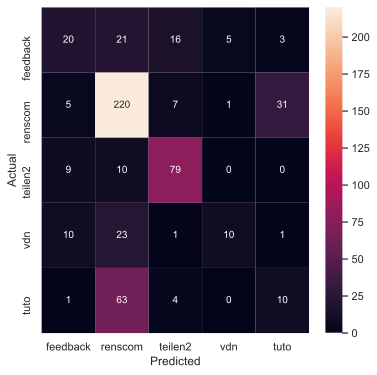

In [76]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.firstusedtextblock.values, yticklabels=category_id_df.firstusedtextblock.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [77]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    feedback       0.44      0.31      0.36        65
     renscom       0.65      0.83      0.73       264
     teilen2       0.74      0.81      0.77        98
        tuto       0.62      0.22      0.33        45
         vdn       0.22      0.13      0.16        78

    accuracy                           0.62       550
   macro avg       0.54      0.46      0.47       550
weighted avg       0.58      0.62      0.58       550



In [78]:
print(labels.nunique())
print(y_train.nunique())
print(y_test.nunique())

5
5
5


### Summary:

- Accuracy = 61.6%
- Precision = 58 % 
- Recall= 62 %
- F1-score= 58 %
- (test samples=550)
- No. of classes in test data=5
- No. classes in train data = 5
- Total classes = 5

### api

- key: text
- output1: class prediction
- output2: probability of each class (higher is better)

In [79]:
texts=["I was asked to test a saal photobook and I was so delighted with the result! It arrived with in 10 days and was of such high quality, with a white leather look cover and an acrylic glass to protect the front photo. It has made a lovely lockdown gift for my best friend."]

In [80]:
text_features = tfidf.transform(texts)
pred_class = model3.predict(text_features)
print('"{}"'.format(texts))
print("  - Predicted as: '{}'".format(pred_class))
print("")

"['I was asked to test a saal photobook and I was so delighted with the result! It arrived with in 10 days and was of such high quality, with a white leather look cover and an acrylic glass to protect the front photo. It has made a lovely lockdown gift for my best friend.']"
  - Predicted as: '['teilen2']'



# END OF NOTEBOOK